# Unsupervised Learning: Clustering Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
from sklearn import metrics
import random

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---

In [12]:
class Cluster():
    def __init__(self, centroid, clusterID):
        self.centroid = centroid
        self.instances = []
        self.clusterID = clusterID
        self.parentCluster = None
        self.isCentroid = False
    def addInstance(self, item):
        self.instances.append(item)
    def numInstances(self):
        return len(self.instances)
    def calculateCentroid(self):
        # go through each item
        sums = []
        for item in range(len(self.instances[0])):
            sum = 0
            # go through each row
            for instance in self.instances:
                sum += instance[item]
            sums.append(sum)

        # average all the sums
        avgs = []
        for sum in sums:
            avgs.append(sum / len(self.instances))
        # print('calculated centroid: ', avgs)
        self.centroid = avgs

    def compare2(self, compareToThis, link_type):
        # this is to compare to centroid (for kmeans)
        if link_type == 2:
            # need to calculate from self.instance[0] because should only have 1 val in here. And then compare to the centroid 
            # of the compareToThis
            temp_distance = 0
            for pos in range(len(self.instances[0])):
                temp_distance += (compareToThis.centroid[pos] - self.instances[0][pos])**2
            temp_distance = np.sqrt(temp_distance)
            return temp_distance
        if link_type == 1:
            # return the distance of the closest values in clusters
            min_distance = np.inf
            for from_instance in self.instances:
                for to_instance in compareToThis.instances:
                    # temp_distance = np.subtract(from_instance, to_instance)
                    temp_distance = 0
                    for pos in range(len(to_instance)):
                        temp_distance += (to_instance[pos] - from_instance[pos])**2

                    temp_distance = np.sqrt(temp_distance)
                    #print(from_instance, to_instance)
                    #print(temp_distance)
                    # temp_distance = np.abs(temp_distance)
                    #print(temp_distance)
                    # temp_distance = np.sum(temp_distance)
                    if temp_distance < min_distance:
                        min_distance = temp_distance
            return min_distance
        else:
            # return the distance of the furthest values in clusters
            max_distance = -1
            for from_instance in self.instances:
                for to_instance in compareToThis.instances:
                    temp_distance = 0
                    for pos in range(len(to_instance)):
                        temp_distance += (to_instance[pos] - from_instance[pos])**2
                    temp_distance = np.sqrt(temp_distance)
                    if temp_distance > max_distance:
                        max_distance = temp_distance
            return max_distance
    def removeInstance(self, instanceToRemove):
        for instance in range(len(self.instances)):
            if instanceToRemove == self.instances[instance]:
                del self.instances[instance]
                return

    def mergeCluster(self, clusterToMergeWith):
        # add instances from merging cluster
        for instance in clusterToMergeWith.instances:
            self.addInstance(instance)
        # caluculate new centroid
        # print('newInstances: ', self.instances)
        self.calculateCentroid()

In [7]:
class HACClustering(BaseEstimator,ClassifierMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.clusters = []
        self.silhouette_score = 0
    
    def fit2(self, X, y=None):
        # create individual clusters for each input value
        for x in range(len(X)):
            tempCluster = Cluster(X[x], x)
            tempCluster.addInstance(X[x])
            self.clusters.append(tempCluster)
        
        while(True):
            if len(self.clusters) % 20 == 0:
                print('nclusters={}'.format(len(self.clusters)))
            # go until number of specified clusters
            if len(self.clusters) == self.k:
                break
            
            smallest_distance = np.inf
            cluster_index_in_list = None
            to_merge_cluster_id = None
            from_merge_cluster_id = None
            from_merge_cluster_idx = None
            # for each from cluster
            from_cluster_position = 0
            for from_cluster in self.clusters:
                # for each to cluster
                to_cluster_position = 0
                for to_cluster in self.clusters:
                    # make sure that cluster will not compare to itself
                    if self.clusters[from_cluster_position].clusterID != self.clusters[to_cluster_position].clusterID:
                        # if single link
                        if self.link_type == 'single':
                            tempDistance = self.clusters[from_cluster_position].compare2(self.clusters[to_cluster_position], 1)
                        # if complete link
                        else:
                            tempDistance = self.clusters[from_cluster_position].compare2(self.clusters[to_cluster_position], 0)
                        
                        if tempDistance < smallest_distance:
                            smallest_distance = tempDistance
                            to_merge_cluster_id = self.clusters[to_cluster_position].clusterID
                            cluster_index_in_list = to_cluster_position
                            from_merge_cluster_id = self.clusters[from_cluster_position].clusterID
                            from_merge_cluster_idx = from_cluster_position    
                    to_cluster_position += 1
                from_cluster_position += 1
            # merge the from cluster with the to cluster
            self.clusters[from_merge_cluster_idx].mergeCluster(self.clusters[cluster_index_in_list])
            # remove the to cluster from the list
            del self.clusters[cluster_index_in_list]


    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # create individual clusters for each input value
        for x in range(len(X)):
            tempCluster = Cluster(X[x], x)
            tempCluster.addInstance(X[x])
            self.clusters.append(tempCluster)
        
        # go until len(self.clusters) == k
        while(True):
            print('begin iter | nclusters={}'.format(len(self.clusters)))
            if len(self.clusters) == self.k:
                break
            # for each cluster
            minValue = np.inf
            clusterIdToMerge = 0
            actualClusterIndex = 0
            for cluster in range(len(self.clusters)):
                # find the closest nearest neighbor/cluster
                # FIXME WILL NEED TO OPTIMIZE THIS PORTION BECAUSE OF NESTED LOOP (IF HAVING TIME ISSUES)
                for cluster2 in range(len(self.clusters)):
                    # make sure that the cluster will not be checked with itself
                    if self.clusters[cluster].clusterID != self.clusters[cluster2].clusterID:
                        # if single link, then do this...
                        if self.link_type == 'single':
                            tempDistance = self.clusters[cluster].compare(self.clusters[cluster2], 1)
                            if  tempDistance < minValue:
                                # SET THE MIN VALUE AND THE ID
                                minValue = tempDistance
                                clusterIdToMerge = self.clusters[cluster2].clusterID
                                actualClusterIndex = cluster2
                        # if complete link, then do this...
                        else:
                            # print('notSingle')
                            tempDistance = self.clusters[cluster].compare(self.clusters[cluster2], 0)
                            if tempDistance < minValue:
                                # SET THE MIN VALUE AND THE ID
                                minValue = tempDistance
                                clusterIdToMerge = self.clusters[cluster2].clusterID
                                actualClusterIndex = cluster2
            # add the value/cluster to the current cluster
            # print('clusterIndexToMergeWith: ', actualClusterIndex)
            self.clusters[cluster].mergeCluster(self.clusters[actualClusterIndex])
            # remove the previous cluster from the list
            del self.clusters[actualClusterIndex]

        return self
    
    def calculate_silhouette(self, X):
        labels = []
        # calculate the labels
        
        for x in X:
            for cluster in self.clusters:
                if x in cluster.instances:
                    labels.append(cluster.clusterID)
        
        self.silhouette_score = metrics.silhouette_score(X, labels)
        return self.silhouette_score

    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        pass

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [13]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output debug_data.arff
debug_data = arff.loadarff('debug_data.arff')
debug_df = pd.DataFrame(debug_data[0])
# print(debug_data.head())
debug_df = debug_df.astype(float)
# print(debug_df.head())
debug_np = debug_df.to_numpy()
debug_np = debug_np.tolist()
# print(debug_np)

def normalizeData(input):
    columns = []
    maxValues = []
    minValues = []

    # for the number of columns
    for item in range(len(input[0])):
        # for each row
        temp = []
        for value in range(len(input)):
            temp.append(input[value][item])

        columns.append(temp)
    
    for item in columns:
        maxValues.append(max(item))
        minValues.append(min(item))
    # print('col: ', columns)
    # print('max: ', maxValues)
    # print('min: ', minValues)
    return maxValues, minValues
original_debug_np = debug_np
maxValues, minValues = normalizeData(debug_np)
for incX in range(len(debug_np)):
    for valX in range(len(debug_np[incX])):
        debug_np[incX][valX] = (debug_np[incX][valX] - minValues[valX]) / (maxValues[valX] - minValues[valX])


# my toy data
toy_data = [[0.8, 0.7], [-0.1, 0.2], [0.9, 0.8], [0, 0.2], [0.2, 0.1], [0.1, 0]]

# Debug Here
model = HACClustering(5, 'complete')
model.fit2(debug_np)

print('numClusters =', len(model.clusters))
print('silhouette score: ', model.calculate_silhouette(original_debug_np))
for cluster in model.clusters:
    print(np.array2string(np.array(cluster.centroid),precision=4,separator=","))
    print(len(cluster.instances))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   733k      0 --:--:-- --:--:-- --:--:--  736k
nclusters=200
nclusters=180
nclusters=160
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
numClusters = 5
silhouette score:  0.3095188332930844
[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71
[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67
[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38
[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16
[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8


### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [14]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval_data.arff
eval_data = arff.loadarff('eval_data.arff')
eval_df = pd.DataFrame(eval_data[0])
eval_df['Class'] = eval_df['Class'].astype(float)
eval_np = eval_df.to_numpy()
eval_np = eval_np.tolist()

def normalizeData(input):
    columns = []
    maxValues = []
    minValues = []

    # for the number of columns
    for item in range(len(input[0])):
        # for each row
        temp = []
        for value in range(len(input)):
            temp.append(input[value][item])

        columns.append(temp)
    
    for item in columns:
        maxValues.append(max(item))
        minValues.append(min(item))
    # print('col: ', columns)
    # print('max: ', maxValues)
    # print('min: ', minValues)
    return maxValues, minValues

maxValues, minValues = normalizeData(eval_np)
for incX in range(len(eval_np)):
    for valX in range(len(eval_np[incX])):
        eval_np[incX][valX] = (eval_np[incX][valX] - minValues[valX]) / (maxValues[valX] - minValues[valX])

# print(eval_df)
# Train on evaluation data using complete link
HAC2 = HACClustering(5, 'complete')
HAC2.fit2(eval_np)
# Print clusters
print('numClusters =', len(HAC2.clusters))
print('silhouette score: ', HAC2.calculate_silhouette(eval_np))
for cluster in HAC2.clusters:
    print(np.array2string(np.array(cluster.centroid),precision=4,separator=","))
    print(len(cluster.instances))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  24871      0 --:--:-- --:--:-- --:--:-- 24871
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
numClusters = 5
silhouette score:  0.2929999090830462
[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49
[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3
[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18
[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49
[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21


#### 1.1.3.1 Single Link

In [16]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval_data.arff
eval_data = arff.loadarff('eval_data.arff')
eval_df = pd.DataFrame(eval_data[0])
eval_df['Class'] = eval_df['Class'].astype(float)
eval_np = eval_df.to_numpy()
eval_np = eval_np.tolist()

def normalizeData(input):
    columns = []
    maxValues = []
    minValues = []

    # for the number of columns
    for item in range(len(input[0])):
        # for each row
        temp = []
        for value in range(len(input)):
            temp.append(input[value][item])

        columns.append(temp)
    
    for item in columns:
        maxValues.append(max(item))
        minValues.append(min(item))
    # print('col: ', columns)
    # print('max: ', maxValues)
    # print('min: ', minValues)
    return maxValues, minValues

maxValues, minValues = normalizeData(eval_np)
for incX in range(len(eval_np)):
    for valX in range(len(eval_np[incX])):
        eval_np[incX][valX] = (eval_np[incX][valX] - minValues[valX]) / (maxValues[valX] - minValues[valX])

# print(eval_df)
# Train on evaluation data using single link
HAC2 = HACClustering(5, 'single')
HAC2.fit2(eval_np)
# Print clusters
print('silhouette score: ', HAC2.calculate_silhouette(eval_np))
print('numClusters =', len(HAC2.clusters))
for cluster in HAC2.clusters:
    print(np.array2string(np.array(cluster.centroid),precision=4,separator=","))
    print(len(cluster.instances))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  45985      0 --:--:-- --:--:-- --:--:-- 45985
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
silhouette score:  0.3971376007060809
numClusters = 5
[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70


### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [53]:
class KMEANSClustering(BaseEstimator,ClassifierMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.clusters = []
        self.beginning_clusters = []
    def fit2(self, X, y=None):
        # create individual clusters for each input value
        for x in range(len(X)):
            tempCluster = Cluster(X[x], x)
            tempCluster.addInstance(X[x])
            self.clusters.append(tempCluster)
        # set the first k instances to starting clusters if debug is true
        if self.debug:
            for i in range(self.k):
                self.clusters[i].isCentroid = True
                self.beginning_clusters.append(self.clusters[i])
                
        else:
            # randomly assign k starting clusters from the data set to be initial k centroids
            for i in range(self.k):
                randNum = random.randint(0, len(self.clusters)-1)
                #print(randNum)
                self.clusters[randNum].isCentroid = True
                self.beginning_clusters.append(self.clusters[randNum])
                del self.clusters[randNum]
        # Repeat until no (or negligible) more changes occur
        numRotations = 0
        previousCentroids = []
        numNoChange = 0
        myhelp = 0
        while(True):
            # print(numNoChange)
            # this is categorizing everything in each of the clusters. 
            if numRotations == 0:
                clusterIdx = 0
                for cluster in self.clusters:
                    min_distance = np.inf
                    whereToAdd = 0
                    finalCnt = 0
                    insertClusterID = None
                    for finalCluster in self.beginning_clusters:
                        # make sure not to comepare the same one with itself
                        if cluster.clusterID != finalCluster.clusterID and not cluster.isCentroid:
                            temp_distance = cluster.compare2(finalCluster, 2)
                            #print('cluster: ', cluster.instances[0])
                            #print('finalCluster: ', finalCluster.instances[0])
                            #print('td: ', temp_distance)
                            if temp_distance < min_distance:
                                min_distance = temp_distance 
                                whereToAdd = finalCnt
                                insertClusterID = cluster.clusterID
                        finalCnt += 1
                    if insertClusterID != None:
                        # print('whereToAdd: ', whereToAdd)
                        # print('clusterID: ', insertClusterID)
                        # need to add cluster to the to add
                        self.beginning_clusters[whereToAdd].mergeCluster(self.clusters[clusterIdx])
                        # self.clusters.parentCluster = whereToAdd
                        # del self.clusters[clusterIdx]
                    else:
                        myhelp += 1
                        print('help', myhelp)

                    clusterIdx += 1
                # add the centroids to the previous centroids
                for finalCluster in self.beginning_clusters:
                    previousCentroids.append(finalCluster.centroid)
            # if we aren't on the first rotation, then we need to compare each of the cluster's values with the other clusters
            else:
                # go through each of the finalClusters
                finalIdx = 0
                for finalCluster in self.beginning_clusters:
                    instanceIdx = 0
                    # go through each of the values in the Final clusters
                    for instance in finalCluster.instances:
                        whereToAdd = None
                        min_distance = self.compare_instance_centroid(instance, finalCluster.centroid)
                        tempIndx = 0
                        # check each centroid
                        for centroid in previousCentroids:
                            temp_distance = self.compare_instance_centroid(instance, centroid)
                            if temp_distance <= min_distance:
                                min_distance = temp_distance
                                whereToAdd = tempIndx
                        if whereToAdd == None:
                            # print('no change')
                            numNoChange += 1
                        elif whereToAdd != finalIdx and len(self.beginning_clusters[finalIdx].instances) > 1:
                            self.beginning_clusters[whereToAdd].addInstance(instance)
                            self.beginning_clusters[finalIdx].removeInstance(instance)

                            tempIndx += 1
                        instanceIdx += 1
                    finalIdx += 1
                # update the previous centroids
                for finalCluster in range(len(self.beginning_clusters)):
                    previousCentroids[finalCluster] = self.beginning_clusters[finalCluster].centroid

            # print('prevCentroids: ', previousCentroids)
            # print(previousCentroids)
            break
            numRotations += 1
            if numNoChange > 1000:
                break

    def compare_instance_centroid(self, instance, centroid):
        temp_distance = 0
        for pos in range(len(instance)):
            temp_distance += (centroid[pos] - instance[pos])
        temp_distance = np.sqrt(temp_distance)
        return temp_distance

    def calculate_silhouette(self, X):
        labels = []
        # calculate the labels
        
        for x in X:
            for cluster in self.beginning_clusters:
                if x in cluster.instances:
                    labels.append(cluster.clusterID)
        
        self.silhouette_score = metrics.silhouette_score(X, labels)
        return self.silhouette_score


    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # create individual clusters for each input value
        for x in range(len(X)):
            tempCluster = Cluster(X[x], x)
            tempCluster.addInstance(X[x])
            self.clusters.append(tempCluster)
        
        change = True
        # beginning_clusters = []
        # if debug then set first 3 instances to starting clusters
        if self.debug:
            for i in range(self.k):
                self.beginning_clusters.append(self.clusters[i])
        else: 
            # randomly assign k starting clusters from the data set to be initial k centroids
            for i in range(self.k):
                randNum = np.random(0, len(self.clusters))
                self.beginning_clusters.append(self.clusters[randNum])
        noChangeCount = 0
        # Repeat until no (or negligible) more changes occur
        while(change):
            if noChangeCount % 2000 == 0:
                print('noChangeCount: ', noChangeCount)
            # if the times no change occurs is greater than 10 break
            if noChangeCount > 100000:
                break
            min_distance_to_cluster = np.inf
            # for each data point
            currentClusterIndex = 0
            for cluster in self.clusters:
                # Group each instance with its closest centroid
                clusterAddIndex = 0
                clusterAddTemp = 0
                for beginning_cluster in self.beginning_clusters:
                    # make sure not to comepare the same one with itself
                    if cluster.clusterID != beginning_cluster.clusterID:
                        temp_distance = cluster.compare(beginning_cluster, 2)
                        if temp_distance < min_distance_to_cluster:
                            min_distance_to_cluster = temp_distance
                            clusterAddIndex = clusterAddTemp
                    clusterAddTemp += 1

                # check to see if instance is already in cluster
                if self.clusters[currentClusterIndex].parentCluster != clusterAddIndex:
                    self.beginning_clusters[clusterAddIndex].mergeCluster(cluster)
                    # Recalculate the centroid based on its new cluster
                    self.beginning_clusters[clusterAddIndex].calculateCentroid()
                    self.clusters[currentClusterIndex].parentCluster = clusterAddIndex
                else:
                    noChangeCount += 1
                currentClusterIndex += 1
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        pass

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [19]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output abalone_debug.arff
abalone_debug = arff.loadarff('abalone_debug.arff')
abalone_df = pd.DataFrame(abalone_debug[0])
# print(abalone_df.head())
abalone_np = abalone_df.to_numpy()
abalone_np = abalone_np.tolist()


def normalizeData(input):
    columns = []
    maxValues = []
    minValues = []

    # for the number of columns
    for item in range(len(input[0])):
        # for each row
        temp = []
        for value in range(len(input)):
            temp.append(input[value][item])

        columns.append(temp)
    
    for item in columns:
        maxValues.append(max(item))
        minValues.append(min(item))
    # print('col: ', columns)
    # print('max: ', maxValues)
    # print('min: ', minValues)
    return maxValues, minValues

maxValues, minValues = normalizeData(abalone_np)
for incX in range(len(abalone_np)):
    for valX in range(len(abalone_np[incX])):
        abalone_np[incX][valX] = (abalone_np[incX][valX] - minValues[valX]) / (maxValues[valX] - minValues[valX])

# my toy data
toy_data = [[0.9, 0.8], [0.2, 0.2], [0.7, 0.6], [-0.1, -0.6], [0.5, 0.5]]

# Train on debug data
kmeans_model = KMEANSClustering(5, True)
kmeans_model.fit2(abalone_np)

# Print clusters
print('numClusters =', len(kmeans_model.beginning_clusters))
print('silhouette score: ', kmeans_model.calculate_silhouette(abalone_np))
for cluster in kmeans_model.beginning_clusters:
    print(np.array2string(np.array(cluster.centroid),precision=4,separator=","))
    print(len(cluster.instances))
print(len(abalone_np))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   943k      0 --:--:-- --:--:-- --:--:--  943k
help 1
help 2
help 3
help 4
help 5
numClusters = 5
silhouette score:  0.23847525317951504
[0.6564,0.6525,0.5376,0.2993,0.2706,0.2886,0.2588,0.6429]
14
[0.3731,0.3561,0.2704,0.0927,0.0929,0.0958,0.0808,0.2211]
29
[0.7851,0.7845,0.6733,0.462 ,0.4268,0.4738,0.3829,0.5248]
89
[0.5627,0.5575,0.4342,0.2077,0.2119,0.2193,0.163 ,0.302 ]
52
[0.156 ,0.132 ,0.1217,0.0251,0.029 ,0.0315,0.0184,0.0882]
16
200


### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [21]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output seismic_data.arff
seismic_data = arff.loadarff('seismic_data.arff')
seismic_df = pd.DataFrame(seismic_data[0])
seismic_df['Class'] = seismic_df['Class'].astype(float)
# print(seismic_df.head())
seismic_np = seismic_df.to_numpy()
seismic_np = seismic_np.tolist()

# Train on evaluation data
kmeans_seismic = KMEANSClustering(5, True)
kmeans_seismic.fit2(seismic_np)

# Print clusters
print('numClusters =', len(kmeans_seismic.beginning_clusters))
print('silhouette score: ', kmeans_seismic.calculate_silhouette(seismic_np))
for cluster in kmeans_seismic.beginning_clusters:
    print(np.array2string(np.array(cluster.centroid),precision=4,separator=","))
    print(len(cluster.instances))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  43189      0 --:--:-- --:--:-- --:--:-- 43189
help 1
help 2
help 3
help 4
help 5
numClusters = 5
silhouette score:  0.24688079038181285
[15.3115,14.807 , 0.8775, 5.6676, 3.3571, 2.7822, 5.3571, 1.35  ]
20
[14.8957,14.5743, 0.8811, 5.5996, 3.3001, 1.2214, 5.172 , 1.    ]
7
[14.3019,14.2948, 0.8792, 5.5289, 3.2306, 3.8524, 5.124 , 1.0741]
27
[13.    ,13.6367, 0.8774, 5.2595, 3.0868, 2.125 , 4.8523, 1.    ]
18
[18.4729,16.1841, 0.8853, 6.168 , 3.6987, 3.4617, 6.0075, 1.8971]
68


LOAD IRIS DATASET

In [22]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris_data.arff
iris_data = arff.loadarff('iris_data.arff')
iris_df = pd.DataFrame(iris_data[0])
iris_df['class'] = iris_df['class'].str.decode('utf-8')

iris_mask = {'Iris-virginica':0, 'Iris-setosa':1, 'Iris-versicolor':2}
iris_df['class'] = iris_df['class'].map(iris_mask)
#myset = set()
#for row in iris_df['class']:
#    myset.add(row)
#print(myset)
print(iris_df.head())
iris_np = iris_df.to_numpy()
iris_np = iris_np.tolist()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  23686      0 --:--:-- --:--:-- --:--:-- 23686
   sepallength  sepalwidth  petallength  petalwidth  class
0          5.1         3.5          1.4         0.2      1
1          4.9         3.0          1.4         0.2      1
2          4.7         3.2          1.3         0.2      1
3          4.6         3.1          1.5         0.2      1
4          5.0         3.6          1.4         0.2      1


## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20


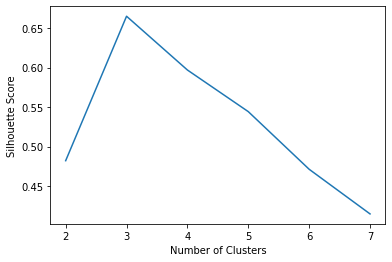

In [25]:
# data not normalized
# Iris Classification using single-link
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model_single_link = HACClustering(i, 'single')
    iris_model_single_link.fit2(iris_np)
    sil_scores.append(iris_model_single_link.calculate_silhouette(iris_np[0:len(iris_np) - 1]))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20


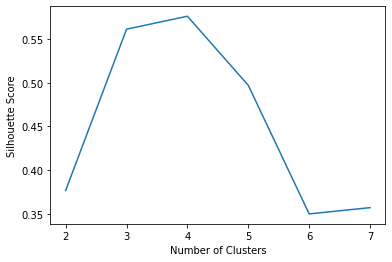

In [26]:
# data not normalized
# Iris Classification using complete-link
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model_complete_link = HACClustering(i, 'complete')
    iris_model_complete_link.fit2(iris_np)
    sil_scores.append(iris_model_complete_link.calculate_silhouette(iris_np[0:len(iris_np) - 1]))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Discuss differences between single-link and complete-link ----------- The difference between single-link and complete-link is that complete-link seems to extend how long and hwo many clusters can achieve a good silhouette score. However, the silhouette score peak is not as high as single-link. 

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20


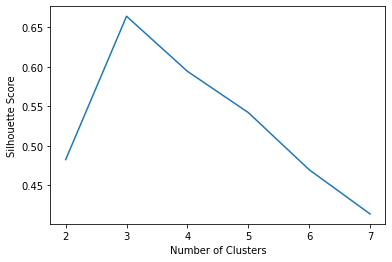

In [27]:
# Clustering Labels using single-link
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model_single_link = HACClustering(i, 'single')
    iris_model_single_link.fit2(iris_np)
    sil_scores.append(iris_model_single_link.calculate_silhouette(iris_np))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20
nclusters=140
nclusters=120
nclusters=100
nclusters=80
nclusters=60
nclusters=40
nclusters=20


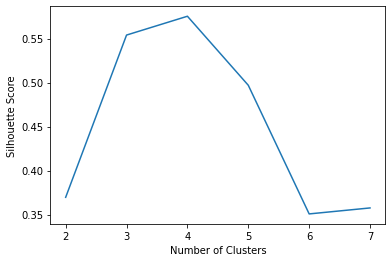

In [28]:
# Clustering Labels using complete-link
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model_complete_link = HACClustering(i, 'complete')
    iris_model_complete_link.fit2(iris_np)
    sil_scores.append(iris_model_complete_link.calculate_silhouette(iris_np))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2. ------------------- To me it seemed that no difference was seen in the data when the final value was included or wasn't Something that could cause this behavior is that I did not normalize the data? So the 0, 1, or 2 values was not very influential as the other features on the classification? But just a thought.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

help 1
help 2
help 1
help 2
help 3
help 1
help 2
help 3
help 4
help 1
help 2
help 3
help 4
help 5
help 1
help 2
help 3
help 4
help 5
help 6
help 1
help 2
help 3
help 4
help 5
help 6
help 7


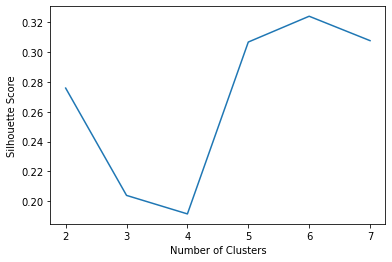

In [45]:
# data not normalized
# Iris Classification without output label
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model= KMEANSClustering(i, True)
    iris_model.fit2(iris_np[0:len(iris_np)-1])
    sil_scores.append(iris_model.calculate_silhouette(iris_np[0:len(iris_np)-1]))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

help 1
help 2
help 1
help 2
help 3
help 1
help 2
help 3
help 4
help 1
help 2
help 3
help 4
help 5
help 1
help 2
help 3
help 4
help 5
help 6
help 1
help 2
help 3
help 4
help 5
help 6
help 7


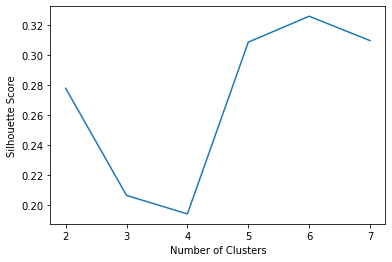

In [46]:
# data not normalized
# Iris Classification with output label
sil_scores = []
k_list = []
for i in range(2, 8):
    iris_model= KMEANSClustering(i, True)
    iris_model.fit2(iris_np)
    sil_scores.append(iris_model.calculate_silhouette(iris_np))
    k_list.append(i)

plt.plot(k_list, sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Compare results and differences between using the output label and excluding the output label -------------- The performance of including vs. excluding the output label as an input values was similar to that of the HAC behavior. There seemed to be no gain or loss with including/excluding the output label. 

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

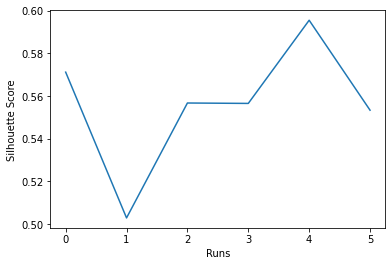

In [75]:
#K-Means 5 times
sil_scores = []
runs = []
for i in range(6):
    iris_model= KMEANSClustering(4, False)
    iris_model.fit2(iris_np)
    sil_scores.append(iris_model.calculate_silhouette(iris_np))
    runs.append(i)

plt.plot(runs, sil_scores)
plt.xlabel('Runs')
plt.ylabel('Silhouette Score')
plt.show()

Discuss any variations in the results ------------------------ It seems to me that each run is highly determined by chance. There was a lot of variation in results when using the random starting centroid. I think that this could be due to the fact that an "outlier" could be chosed as a centroid, and that would lead to worse silhouette scores. Or on the other hand, very central points could be chosen.

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

In [79]:

# Load sklearn
sil_scores = []
ch_scores = []
nclust = []
for i in range(2,8):
    HAC = AgglomerativeClustering(n_clusters=i, compute_distances=True)
    HAC.fit(iris_np)
    labels = HAC.labels_
    print(i)
    print('silhouette score:', silhouette_score(iris_np, labels))
    print('calinski harabasz score:', metrics.calinski_harabasz_score(iris_np, labels))
    sil_scores.append(silhouette_score(iris_np, labels))
    ch_scores.append(metrics.calinski_harabasz_score(iris_np, labels))
    nclust.append(i)

2
silhouette score: 0.6191370111155101
calinski harabasz score: 305.1196770343371
3
silhouette score: 0.6642551697080866
calinski harabasz score: 568.5477453046756
4
silhouette score: 0.6149378204757433
calinski harabasz score: 512.1317642212049
5
silhouette score: 0.5444631147468306
calinski harabasz score: 512.0100772427022
6
silhouette score: 0.520075309511409
calinski harabasz score: 492.90284653860806
7
silhouette score: 0.3940948537089053
calinski harabasz score: 499.0061907717969


*Record impressions* ------------ based off of the silhouette score, it is plain to see that the best number of clusters is 3. However, using the calinski harabasz score, it can be a little more misleading on what is "best". It doesn't exactly follow the silhouette score, but the general trend can be seen. I thought it was interesting in the case of 6 and 7 clusters. The silhouette score went down between those two iterations, but the CHS went up! I noticed that the hyper-parameters that I tried did not affect performance very much.

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

In [76]:
# Load sklearn 
sil_scores = []
ch_scores = []
nclust = []
for i in range(2,8):
    kmeans = KMeans(n_clusters=i, max_iter=500)
    kmeans.fit(iris_np)
    labels = kmeans.labels_
    #print(labels)
    print(i)
    print('silhouette score:', silhouette_score(iris_np, labels))
    print('calinski harabasz score:', metrics.calinski_harabasz_score(iris_np, labels))
    sil_scores.append(silhouette_score(iris_np, labels))
    ch_scores.append(metrics.calinski_harabasz_score(iris_np, labels))
    nclust.append(i)



2
silhouette score: 0.6115675049578069
calinski harabasz score: 310.38639310648654
3
silhouette score: 0.6642551697080866
calinski harabasz score: 568.5477453046756
4
silhouette score: 0.6060219472559426
calinski harabasz score: 514.0075330099777
5
silhouette score: 0.5346292566942061
calinski harabasz score: 515.2144191295586
6
silhouette score: 0.522030400060065
calinski harabasz score: 494.40660066994803
7
silhouette score: 0.3981501759264689
calinski harabasz score: 500.05328810955046


*Record impressions* ----- The distribution of the calinski harabasz score was fairly similar for kmeans as it was for HAC. It also had very similar behavior in cases where the silhouette score would drop, but the CHS would increase. It is slightly higher for the kmeans algorithm, but only by ~3 points. I noticed that the hyper-parameters that I tried did not affect performance very much.

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [ ]:
# Copy function Below